# Variational Autoencoder
___
* see training - loss etc
* compare x and x_dach


In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import json

In [2]:
from pathlib import Path
path = str(Path(os.getcwd()).parent.parent)

import sys
sys.path.insert(0,path)

from breakout.vae.vae import ConvVAE

In [3]:
path = '/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v2/200228'
obs_path = path + '/record'
LATENT_DIM = 32
vae_path = path +'/tf_vae'
trainparam_path = path + '/tf_vae/vae_train_param.json'
batch_size=400

In [4]:
LATENT_DIM = 32

In [6]:
def load_raw_data_list(filelist):
    data_list = []
    action_list = []
    counter = 0
    for i in range(len(filelist)):
        filename = filelist[i]
        raw_data = np.load(os.path.join(obs_path, filename))
        data_list.append(raw_data['obs'])
        action_list.append(raw_data['action'])
        if ((i+1) % 1000 == 0):
            print("loading file", (i+1))
    return data_list, action_list

In [7]:
filelist = os.listdir(obs_path)
dataset, action_dataset = load_raw_data_list(filelist[0:10])
dataset[0].shape

(400, 64, 64, 3)

## Compare Input and Output of VAE

In [9]:
vae = ConvVAE(z_size=32,
              batch_size=batch_size,
              learning_rate=0.0001,
              kl_tolerance=0.5,
              is_training=False,
              reuse=False,
              gpu_mode=True)
vae.load_json(os.path.join(vae_path,'vae.json'))

obs = dataset[5]
z = vae.encode(obs) 
z_dec = vae.decode(z)

INFO:tensorflow:Model using gpu.


In [9]:
obs = np.array(obs, dtype=np.float32)

In [10]:
def plot_results(n,frame_nb, obs, z_dec):
    
    n_plots = n * 2
    i = 1
    while i < n_plots + 1:
        if i % 2 == 1:
            plt.subplot(n,2,i)
            plt.title(f"{i},{frame_nb}")
            plt.imshow(obs[frame_nb])
            plt.axis('off')
        else:
            plt.subplot(n,2,i)
            plt.title(f"{i},{frame_nb}")
            plt.imshow(z_dec[frame_nb])
            frame_nb += 1
            plt.axis('off')
        i += 1
    plt.show()    
    

In [11]:
z_dec.max()

0.89338338

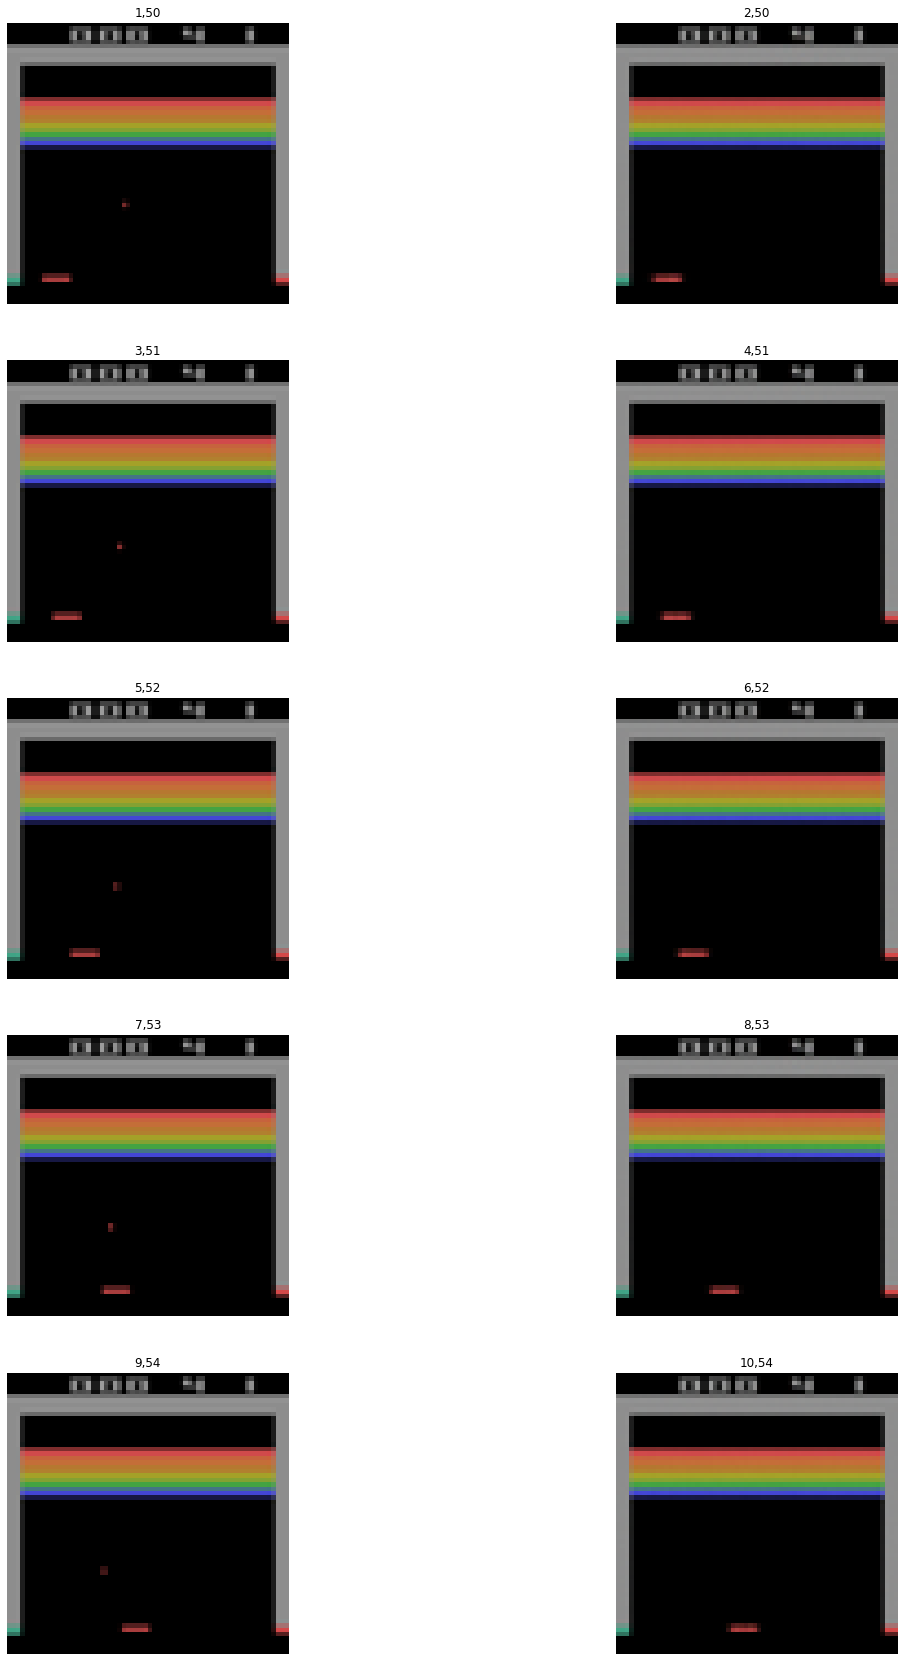

In [12]:
plt.figure(figsize=(20,30))
plot_results(n=5, frame_nb=50,obs=obs, z_dec=z_dec)

### Sample z from normal distribution

In [13]:
vae = ConvVAE(z_size=32,
              batch_size=16,
              learning_rate=0.0001,
              kl_tolerance=0.5,
              is_training=False,
              reuse=False,
              gpu_mode=True)
vae.load_json(os.path.join(vae_path,'vae.json'))

INFO:tensorflow:Model using gpu.


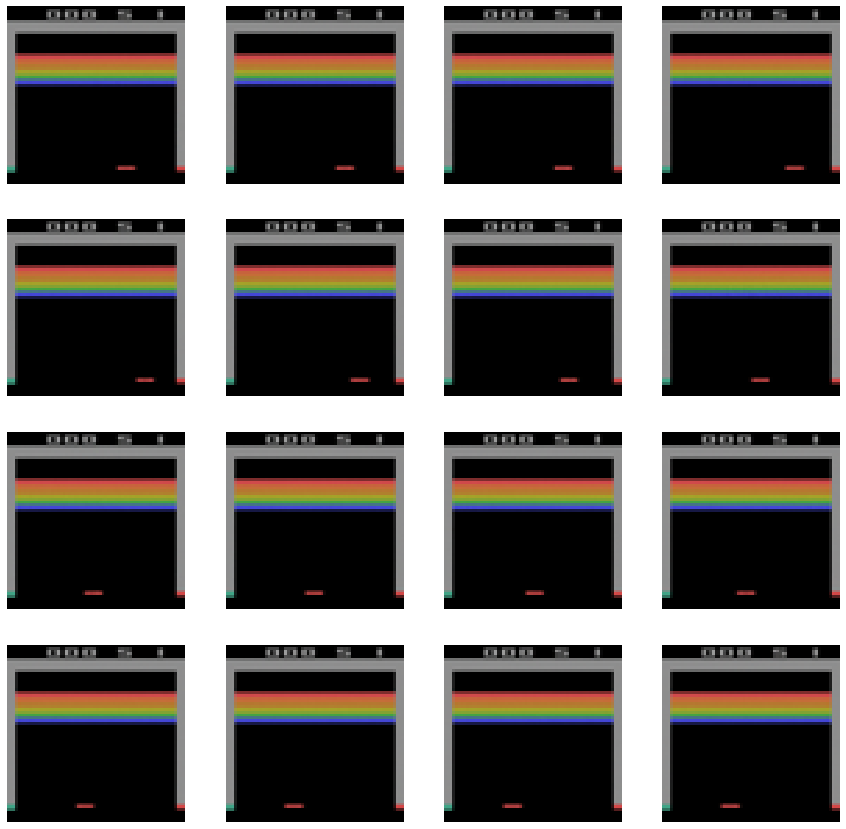

In [51]:
# z from normal distrib
num_examples_to_generate = 16
random_vec_for_generation = np.random.normal(size=(num_examples_to_generate, LATENT_DIM)) 
#tf.random_normal(shape=(num_examples_to_generate, LATENT_DIM))
#z_dec = vae.decode(random_vec_for_generation)
fig = plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(z_dec[i, :, :, :])
    plt.axis('off')
plt.show()

## Z distribution

In [16]:
z[0].shape

(32,)

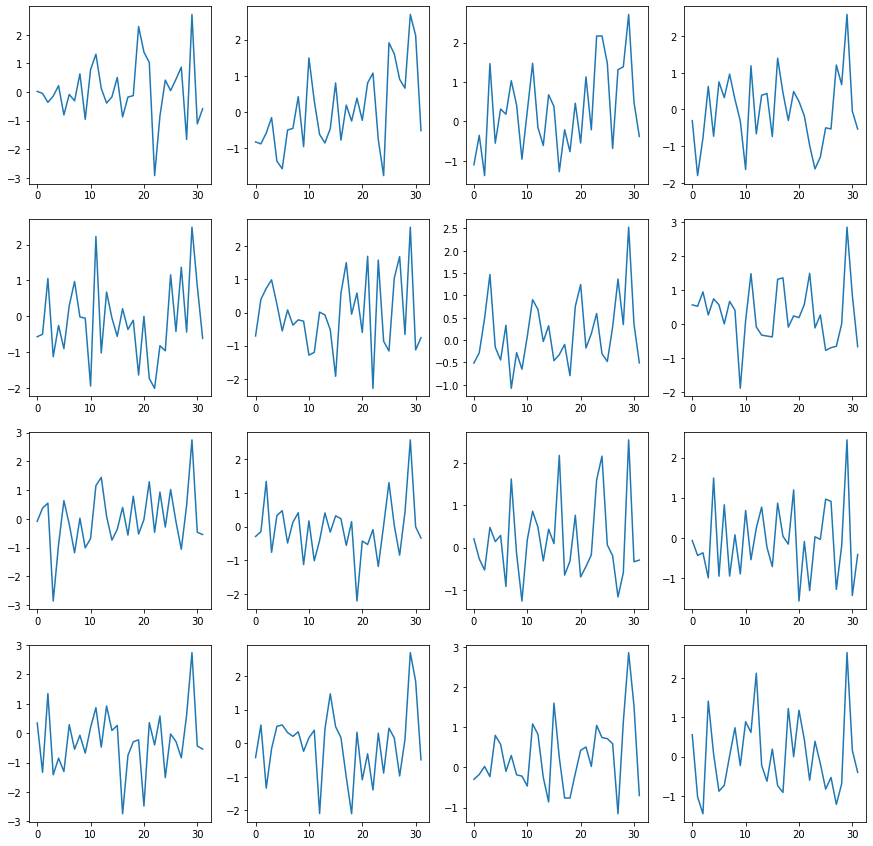

In [17]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(z[i].reshape(32))

## Compare Mu and LogVar

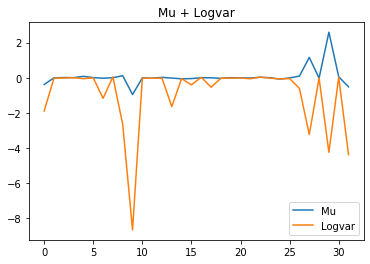

[ 0  6  8  9 13 15 17 26 27 29 31]
11


In [23]:
obs = dataset[0]
mu, logvar = vae.encode_mu_logvar(obs)
mu.shape
plt.title('Mu + Logvar')
plt.plot(mu[0], label='Mu')
plt.plot(logvar[0], label = 'Logvar')
plt.legend(loc='lower right')
plt.show()
info_var = np.where(abs(logvar[0])>0.1)
print(info_var[0])
print(len(info_var[0]))

## See Training Param

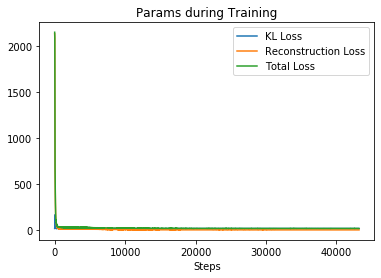

In [19]:
with open(trainparam_path, 'r') as file:
    train_param = json.load(file)
kl_loss = []
r_loss = []
train_loss = []
for item in train_param:
    kl_loss.append(item['kl_loss'])
    r_loss.append(item['r_loss'])
    train_loss.append(item['train_loss'])

plt.plot(kl_loss, label='KL Loss')
plt.plot(r_loss, label='Reconstruction Loss')
plt.plot(train_loss, label='Total Loss')
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.title('Params during Training')
plt.show()

## Video Sequence


In [22]:
import base64
import imageio
import IPython

In [48]:
z_dec[0].shape

(64, 64, 3)

In [23]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [50]:
filename = 'vae_200228.mp4'
with imageio.get_writer(filename, mode='I') as video:    
    for image in range(399):
        video.append_data(np.array(z_dec[image]*255, dtype=np.uint8))
embed_mp4(filename,video)